# Rain in Australia

**Context**

Predict next-day rain by training classification models on the target variable RainTomorrow.

**Content**

This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

**Instructions**

1.   Copy the rain folder to the project directory
2.   Check the the file 'weatherAUS.csv' is in the copied rain directory

In [ ]:
# Python ≥3.6.9 is required
import sys
assert sys.version_info >= (3, 6, 9)

# Common imports
import numpy as np
import os
import pandas as pd
import time

# to make this notebook's output stable across runs
np.random.seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 1. Load the Data 

In [ ]:
# Path of the Data File

df_path = "./rain/weatherAUS.csv"

df = pd.read_csv(df_path)

# 2. Data Exploration 

In [ ]:
# First Rows of the Data

df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


In [ ]:
# Summary of the Data
# We obtain 22 columns composed of:
# - Float64 and object types
# - Missing values in all columns other than Date and Location

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
# Set date to datetime object

df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


,Available,Missing,Missing %
Sunshine,75625,69835,48.01
Evaporation,82670,62790,43.17
Cloud3pm,86102,59358,40.81
Cloud9am,89572,55888,38.42
Pressure9am,130395,15065,10.36
Pressure3pm,130432,15028,10.33


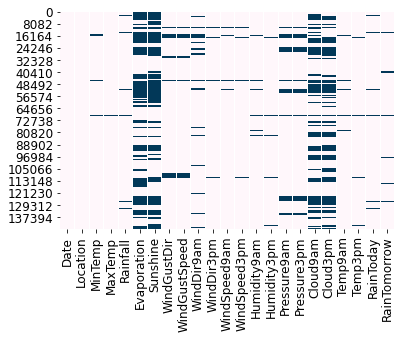

In [ ]:
# Find what columns have missing values

import seaborn as sns
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')

available = df.count().sort_values()
missing = df.isnull().sum().sort_values()
percent = ( 100 * missing / df.count().max() ).round(decimals=2)
total = pd.concat([available, missing, percent], axis=1, keys=['Available', 'Missing', 'Missing %'])
total.head(6)

# Sunshine, Evaporation, Cloud3pm and Cloud9am has 38.42% of missing data

In [ ]:
# We learned from the problem statement that it is a rainy day when Rainfall is greater than 1mm
# Therefore we can look into the colums Rainfall and RainToday 
# Check if (Nan in Rainfall == Nan in RainToday)

pa = df.loc[df["Rainfall"].isnull(), ["Rainfall"]]        # Get column of NULL Rainfall
pa = pa.fillna(0)                                                   # Fill NaN with 0 for comparisson (Pandas Limitation)
pb = df.loc[df["Rainfall"].isnull(), ["RainToday"]]       # Get column of NULL RainToday
pb = pb.fillna(0)                                                   # Fill NaN with 0 for comparisson (Pandas Limitation)
pb = pb.rename(columns={"RainToday":"Rainfall"})                    # Rename RainToday colum to Rainfall

equals = pa.eq(pb)                                                  # Elemnet-wise comparisson, same as: equals = (pa == pb)
equals.any(axis=None)

# The answer is YES, we have every Nan in Rainfall equals to Nan in RainToday

True

In [ ]:
# We also know that RainTomorrow is the column that needs to be predicted
# Rainfall has 142199 records, whereas RainTomorrow has 142193
# The difference is only 7 records.
# Let's find out why

pd1 = df["RainTomorrow"].isnull()              # Find RainTomorrow NaN
pd1.rename("Rain", inplace=True)                    # Rename series for later comparisson
pd2 = df["Rainfall"].notna()                   # Find RainFall is not NaN
pd2 = pd.Series(data=np.append(pd2[1:].values,False), index=pd2.index.values, name="Rain")  # Build Panda Series, ignore index 0 - Shift left series, add dummy/cancelling False

idx_Previous_Day = (pd1 & pd2).loc[(pd1 & pd2) == True].index.values   # Index of Previous days with RainTomorrow NaA
idx_Actual_RainFall_Day = idx_Previous_Day + 1                                # Index of Actual Rain Day
idx_Both_Day = np.append(idx_Actual_RainFall_Day,idx_Previous_Day)   # Indexes of Previous and Actual Rain Day
idx_Both_Day.sort()     # Sort Values

# Show why RainTomorrow was not recorded the 7 Cases 
df.loc[idx_Both_Day, ["Date","Location", "Rainfall","RainToday","RainTomorrow"]]

# The 7 x NaN is due to the fact that it is Last day of data for each Location

,Date,Location,Rainfall,RainToday,RainTomorrow
99512,2017-06-25,Adelaide,0.0,No,NaN
99513,2008-12-01,MountGambier,4.0,Yes,No
102552,2017-06-25,MountGambier,0.6,No,NaN
102553,2009-01-01,Nuriootpa,0.0,No,No
105561,2017-06-25,Nuriootpa,0.0,No,NaN
105562,2009-01-01,Woomera,0.0,No,No
108570,2017-06-25,Woomera,0.0,No,NaN
108571,2008-12-01,Albany,0.0,No,No
139110,2017-06-25,AliceSprings,0.0,No,NaN
139111,2008-07-01,Darwin,0.0,No,No


In [ ]:
# Let's drop those 7 Nan of idx_Previous_Day

df.drop(index=idx_Previous_Day, inplace=True)

In [ ]:
# How many unique Locations are?

Locations = df["Location"].unique()
print( "Locations: ", Locations, "\n Total: ",Locations.shape[0])

# 49 Locations

Locations:  ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru'] 
 Total:  49


In [ ]:
# Let see what happens with RainTomorrow when date "2017-06-25"

df.loc[df["Date"] == "2017-06-25", ["Date","Location", "Rainfall","RainToday","RainTomorrow"]]

,Date,Location,Rainfall,RainToday,RainTomorrow
3039,2017-06-25,Albury,0.0,No,Yes
6048,2017-06-25,BadgerysCreek,0.2,No,No
9057,2017-06-25,Cobar,0.0,No,No
12066,2017-06-25,CoffsHarbour,0.0,No,No
15075,2017-06-25,Moree,0.0,No,No
21118,2017-06-25,NorahHead,0.0,No,No
24127,2017-06-25,NorfolkIsland,3.8,Yes,No
27166,2017-06-25,Penrith,0.0,No,No
30175,2017-06-25,Richmond,0.2,No,No
33519,2017-06-25,Sydney,0.0,No,No


In [ ]:
# Let's drop the last row for Location Uluru: index=145459

df.drop(index=df.last_valid_index(), inplace=True)

In [ ]:
# Let's investigate now the relevance of each feature (column) by finding Correlactions

df.dropna(inplace=True)  # Drops all NaN
df.shape

(56420, 23)

In [ ]:
# Convert categorical values to Numerical values
# Columns: "Date","RainTomorrow", "RainToday", "Location", "WindDir3pm", "WindDir9am", "WindGustDir"

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df[["Date","RainTomorrow", "RainToday", "Location", "WindDir3pm", "WindDir9am", "WindGustDir"]] = ordinal_encoder.fit_transform(df[["Date","RainTomorrow", "RainToday", "Location", "WindDir3pm", "WindDir9am", "WindGustDir"]])

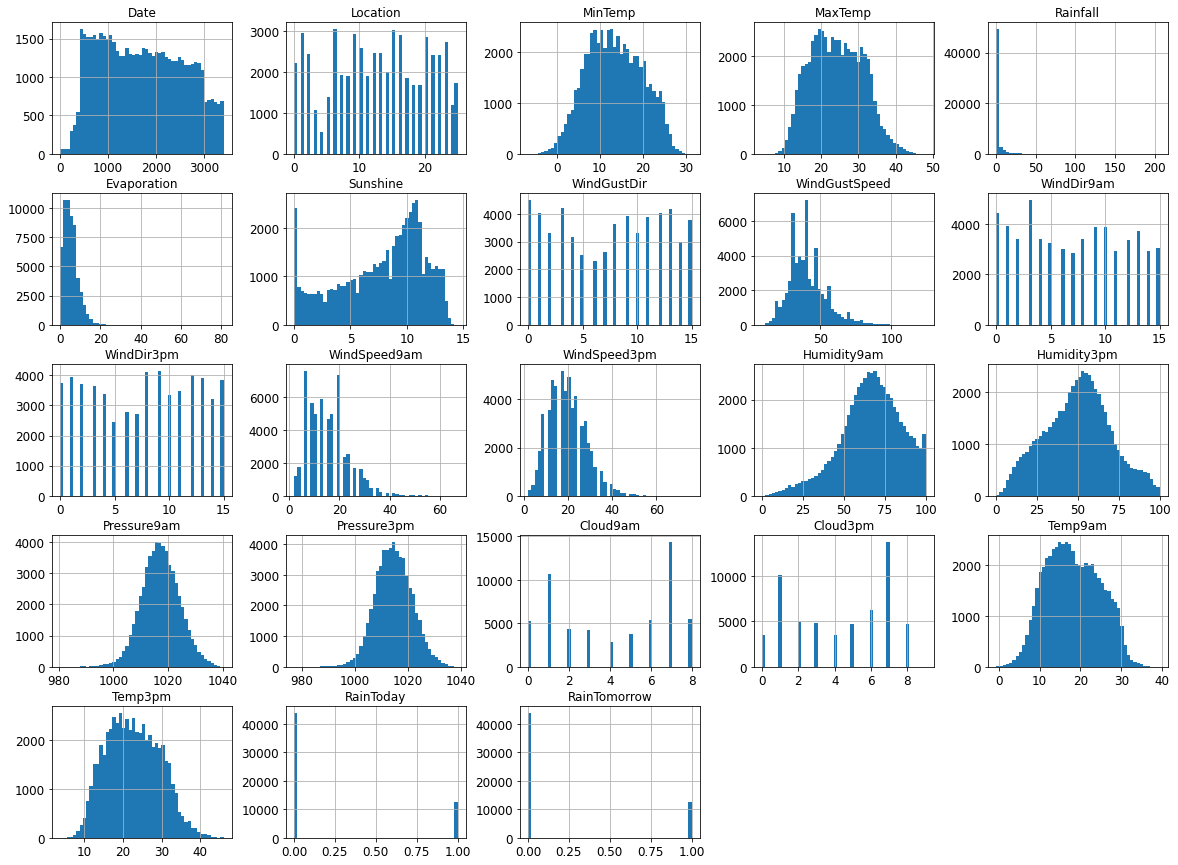

In [ ]:
# Let's check feature skewness, range and frequency distribution using histogram plots

df.hist(bins=50, figsize=(20,15))
plt.show()

# We found that Rainfall, Evaporation has significant outliers

In [ ]:
# Remove the outliers
# Using Z-score to detect and remove the outliers

from scipy import stats
z = np.abs(stats.zscore(df._get_numeric_data()))
df= df[(z < 3).all(axis=1)]
df.shape

(53196, 23)

**Cross-Correlation**

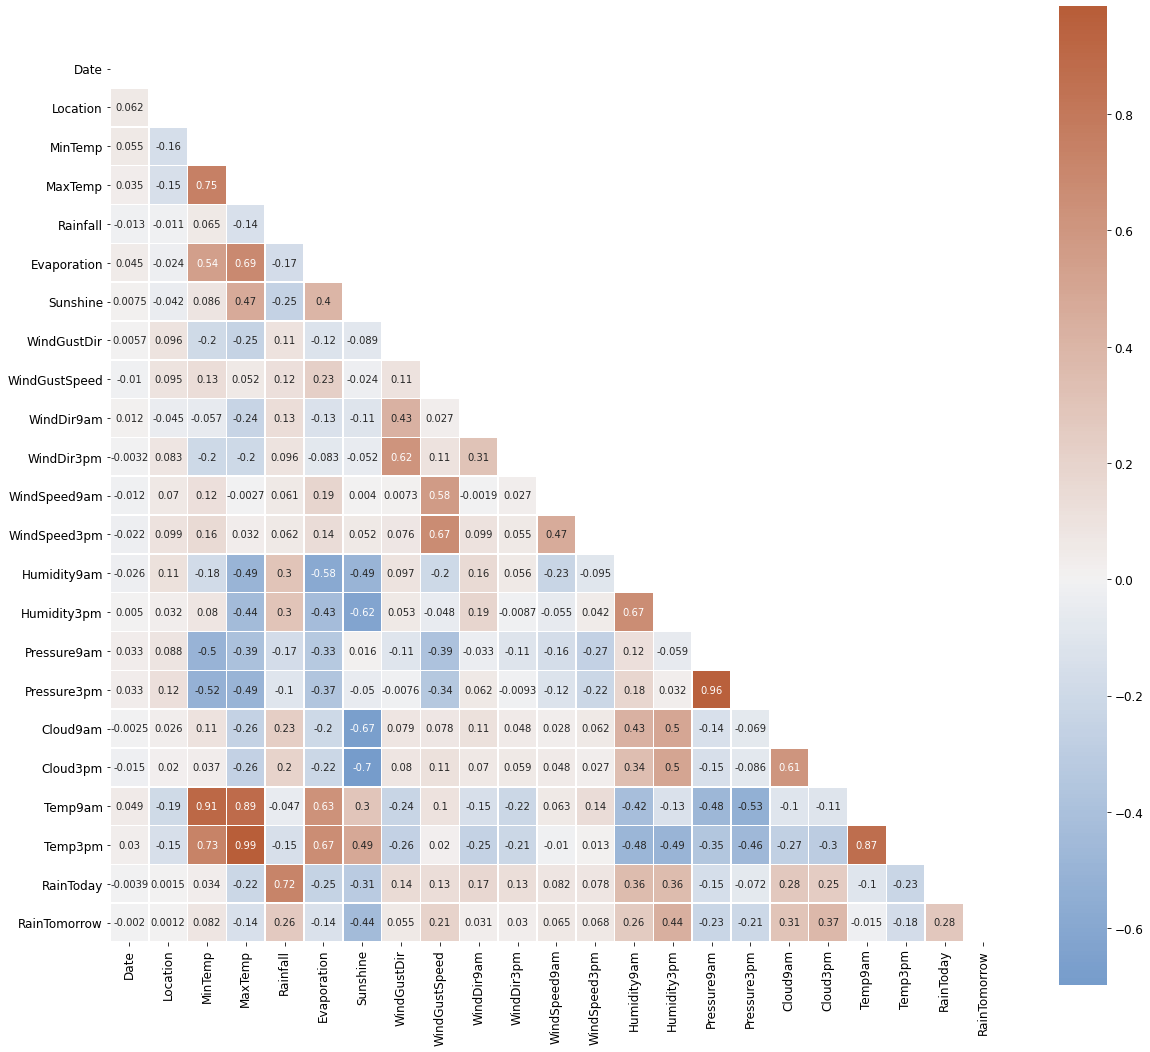

In [ ]:
# Find Correlaction between different Features and RainTomorrow

corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [ ]:
# Find Correlaction between different Features and RainTomorrow

corr_matrix["RainTomorrow"].sort_values(ascending=False)

RainTomorrow     1.000000
Humidity3pm      0.443117
Cloud3pm         0.374831
Cloud9am         0.307426
RainToday        0.279697
Rainfall         0.263484
Humidity9am      0.256240
WindGustSpeed    0.209008
MinTemp          0.082386
WindSpeed3pm     0.068492
WindSpeed9am     0.065246
WindGustDir      0.054991
WindDir9am       0.030790
WindDir3pm       0.029714
Location         0.001150
Date            -0.001958
Temp9am         -0.015213
Evaporation     -0.137866
MaxTemp         -0.140594
Temp3pm         -0.175998
Pressure3pm     -0.205236
Pressure9am     -0.229365
Sunshine        -0.436171
Name: RainTomorrow, dtype: float64

**Feature Selection**

In [ ]:
# Consider only High correlation Data
# Drop other features

df = df.drop(columns=corr_matrix.index[
                                       (corr_matrix["RainTomorrow"].values < 0.029714) & 
                                       (corr_matrix["RainTomorrow"].values > -0.015213)])

# df = df.drop(columns=corr_matrix.index[
#                                                      (corr_matrix["RainTomorrow"].values <= 0.25) & 
#                                                      (corr_matrix["RainTomorrow"].values >= -0.25)])

In [ ]:
# Standardize the data
# Using MinMaxScaler rather than StandardScaler to avoid negative values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

# Data Imbalance

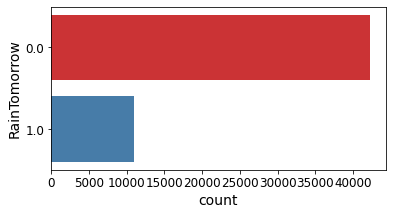

In [ ]:
# Check for imbalance between Yes/No count of RainTomorrow

f, ax = plt.subplots(figsize=(6, 3))
ax = sns.countplot(y="RainTomorrow", data=df, palette="Set1")
plt.show()

# As you can see there are more Dry Days (0) than Rainy Dates (1)
# Let's use f1 as metric

# The Imbalance can be handled with the following methods:
# https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html

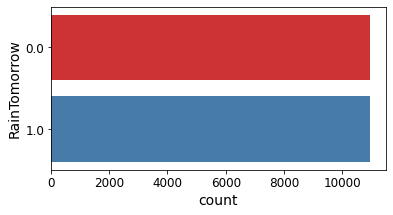

In [ ]:
# Let's handle the imbalance with undersampling
from sklearn.utils import resample

no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
# yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
no_undersampled = resample(no, replace=True, n_samples=len(yes), random_state=123)

# df = pd.concat([no, yes_oversampled])
df = pd.concat([no_undersampled, yes])


f, ax = plt.subplots(figsize=(6, 3))
ax = sns.countplot(y="RainTomorrow", data=df, palette="Set1")
plt.show()

# Model Training

In [ ]:
# Get Training and Test Sets
from sklearn.model_selection import train_test_split

X = df.drop(columns="RainTomorrow")
y = df[['RainTomorrow']].values.ravel()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

**1. Logistic Regression Model**

In [ ]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


t0=time.time()
clf_logreg = LogisticRegression(max_iter=200)
clf_logreg.fit(X_train,y_train)
y_pred = clf_logreg.predict(X_test)
f1 = f1_score(y_test,y_pred)
print('F1 Score :',f1)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy :',accuracy)
print('Time taken :' , time.time()-t0)

F1 Score : 0.7926374650512581
Accuracy : 0.7968963943404838
Time taken : 0.4142439365386963


**2. Random Forest Model**

In [ ]:
# Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

t0=time.time()
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=8)
clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print('F1 Score :',f1)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy :',accuracy)
print('Time taken :' , time.time()-t0)

F1 Score : 0.7993637809588731
Accuracy : 0.7984938384299407
Time taken : 2.3252334594726562


**3. XGB Boost Classifier**

In [ ]:
# XGB Boost Classifier
import xgboost as xgb

params_xgb ={'n_estimators': 100,
            'max_depth': 8}

t0=time.time()
model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
f1 = f1_score(y_test,y_pred)
print('F1 Score :',f1)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy :',accuracy)
print('Time taken :' , time.time()-t0)

F1 Score : 0.8206309002993323
Accuracy : 0.8222272934732998
Time taken : 3.974730968475342


# Conclusion

This kernel achieves an Accuracy and F1 Score of around 82% using XGB Model.

It handles data inbalance with undersampling.

WORK IN PROGRESS: Improves the performance

